## Baisc Import

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm

from torchcp.classification.loss import ConfTr
from torchcp.classification.predictors import ClusterPredictor, ClassWisePredictor, SplitPredictor, WeightedPredictor
from torchcp.classification.scores import THR, APS, SAPS, RAPS, Margin
from torchcp.classification import Metrics
from torchcp.utils import fix_randomness

import seaborn as sns
import matplotlib.pyplot as plt

## Hyper-parameters

In [2]:
seed = 123
alpha = 0.05
BATCH_SIZE = 128
NUM_EPOCHS = 5

## Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset: FashionMNIST

In [4]:
transform_fmnist_train = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,)),
])

transform_fmnist_test = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.2868,), (0.3524,)),
])

train_set = torchvision.datasets.FashionMNIST(root='/shareddata', train=True,
                                       download=True, transform=transform_fmnist_train)
train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_set = torchvision.datasets.FashionMNIST(root='/shareddata', train=False,
                                       download=True, transform=transform_fmnist_test)
test_set_size = len(test_set) // 2
cal_set_size = len(test_set) - test_set_size

cal_dataset, test_dataset = torch.utils.data.random_split(test_set, [cal_set_size, test_set_size])
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
# test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
dataset_name = 'FashionMNIST'

## Model: MLP

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(224*224*3, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [6]:
model = MLP()
model.to(device)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=150528, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Train

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.train()

for epoch in range(NUM_EPOCHS):
    model.train()
    for images, labels in train_data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
torch.save(model, 'model.pth')

model = torch.load('model.pth')

model.eval()

corrects = 0
total = 0

with torch.no_grad():
    for images, labels in test_data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        corrects += (predicted == labels).sum().item()

acc =corrects / total
print(f"Accuracy on FashionMNIST: {acc * 100:.4f}%")

Accuracy on FashionMNIST: 86.2200%


## Conformal Prediction

In [8]:
def c_prediction(model,sfunction, predictor):
    model.eval()

    score_function = sfunction
    predictor = predictor(score_function, model)

    predictor.calibrate(cal_data_loader, alpha)                
    result = predictor.evaluate(test_data_loader)
    print(f"Result--Coverage_rate: {result['Coverage_rate']}, Average_size: {result['Average_size']}")
    return result['Coverage_rate'],result['Average_size']

## Experiment

In [12]:
predictors = [ClusterPredictor, ClassWisePredictor, SplitPredictor]
scores = [THR(), APS(), SAPS(0.5), RAPS(0.5,0)]
setting1 = ['CP+THR','CP+APS','CP+SAPS','CP+RAPS','CWP+THR','CWP+APS','CWP+SAPS','CWP+RAPS','SP+THR','SP+APS','SP+SAPS','SP+RAPS']
sapss = [SAPS(0.3),SAPS(0.7)]
setting2 = ['CP+SAPS.3','CP+SAPS.7','CWP+SAPS.3','CWP+SAPS.7','SP+SAPS.3','SP+SAPS.7']
rapss = [RAPS(0.3,0),RAPS(0.7,0)]
setting3 = ['CP+RAPS.3','CP+RAPS.7','CWP+RAPS.3','CWP+RAPS.7','SP+RAPS.3','SP+RAPS.7']

In [13]:
Coverage_rates1 = []
Average_sizes1 = []
Coverage_rates2 = []
Average_sizes2 = []
Coverage_rates3 = []
Average_sizes3 = []

### Comparison within Different Predictors and Scores

In [14]:
for i in predictors:
    for j in scores:
        Coverage_rate,Average_size = c_prediction(model , sfunction = j, predictor = i)
        Coverage_rates1.append(Coverage_rate)
        Average_sizes1.append(Average_size)

Result--Coverage_rate: 0.951, Average_size: 1.3232
Result--Coverage_rate: 0.9454, Average_size: 1.5416
Result--Coverage_rate: 0.9452, Average_size: 1.4956
Result--Coverage_rate: 0.9514, Average_size: 1.4198
Result--Coverage_rate: 0.9456, Average_size: 1.368
Result--Coverage_rate: 0.9534, Average_size: 1.5662
Result--Coverage_rate: 0.9446, Average_size: 1.589
Result--Coverage_rate: 0.9484, Average_size: 1.6932
Result--Coverage_rate: 0.95, Average_size: 1.3184
Result--Coverage_rate: 0.9476, Average_size: 1.5542
Result--Coverage_rate: 0.9508, Average_size: 1.5486
Result--Coverage_rate: 0.9484, Average_size: 1.3758


### Comparison SAPS within Different Weights

In [15]:
for i in predictors:
    for j in sapss:
        Coverage_rate,Average_size = c_prediction(model, sfunction = j, predictor = i)
        Coverage_rates2.append(Coverage_rate)
        Average_sizes2.append(Average_size)

Result--Coverage_rate: 0.9496, Average_size: 1.385
Result--Coverage_rate: 0.9516, Average_size: 1.6386
Result--Coverage_rate: 0.949, Average_size: 1.5494
Result--Coverage_rate: 0.9488, Average_size: 1.6674
Result--Coverage_rate: 0.9486, Average_size: 1.3816
Result--Coverage_rate: 0.9512, Average_size: 1.6202


### Comparison RAPS within Different Penalties

In [16]:
for i in predictors:
    for j in sapss:
        Coverage_rate,Average_size = c_prediction(model, sfunction = j, predictor = i)
        Coverage_rates3.append(Coverage_rate)
        Average_sizes3.append(Average_size)

Result--Coverage_rate: 0.9452, Average_size: 1.3728
Result--Coverage_rate: 0.951, Average_size: 1.6294
Result--Coverage_rate: 0.9458, Average_size: 1.577
Result--Coverage_rate: 0.9488, Average_size: 1.6856
Result--Coverage_rate: 0.9512, Average_size: 1.3978
Result--Coverage_rate: 0.9532, Average_size: 1.63


## Visualization

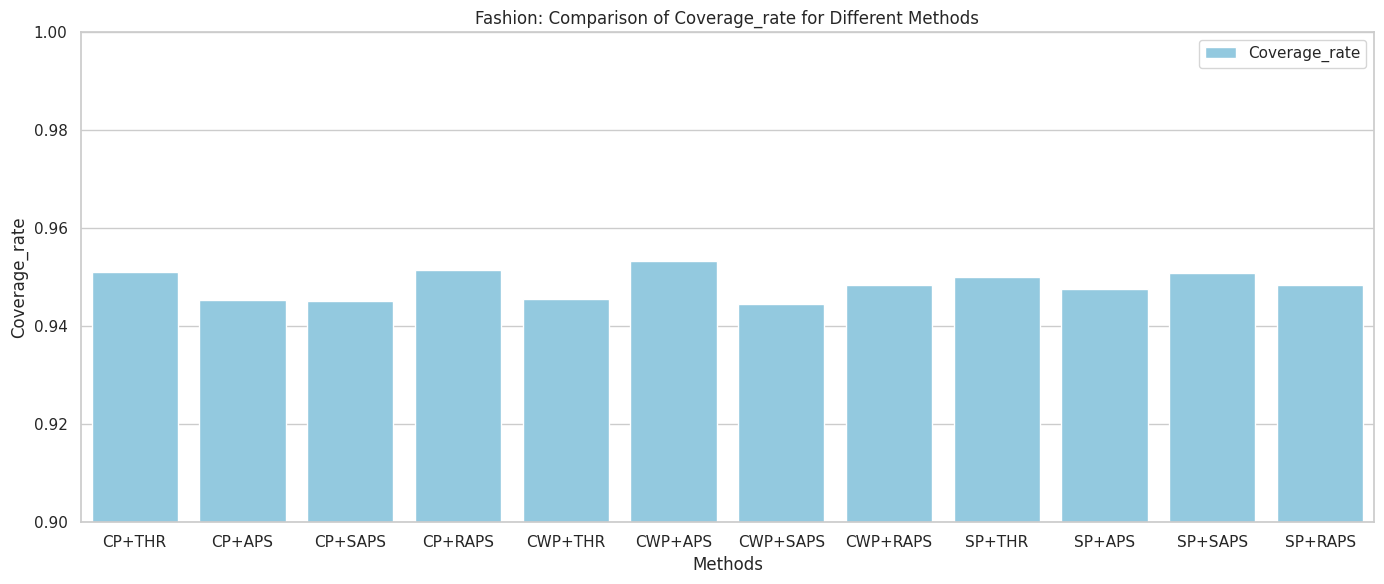

In [35]:
sns.set_theme()
sns.set(style="whitegrid", palette="deep")

plt.figure(figsize=(14, 6))

sns.barplot(x=setting1, y=Coverage_rates1,  color='skyblue', label='Coverage_rate')

plt.xlabel('Methods')
plt.ylabel('Coverage_rate')
plt.title('Fashion: Comparison of Coverage_rate for Different Methods')
# plt.xticks(rotation=45, ha='right')
plt.ylim(0.9,1)
plt.legend()

plt.tight_layout()
plt.show()

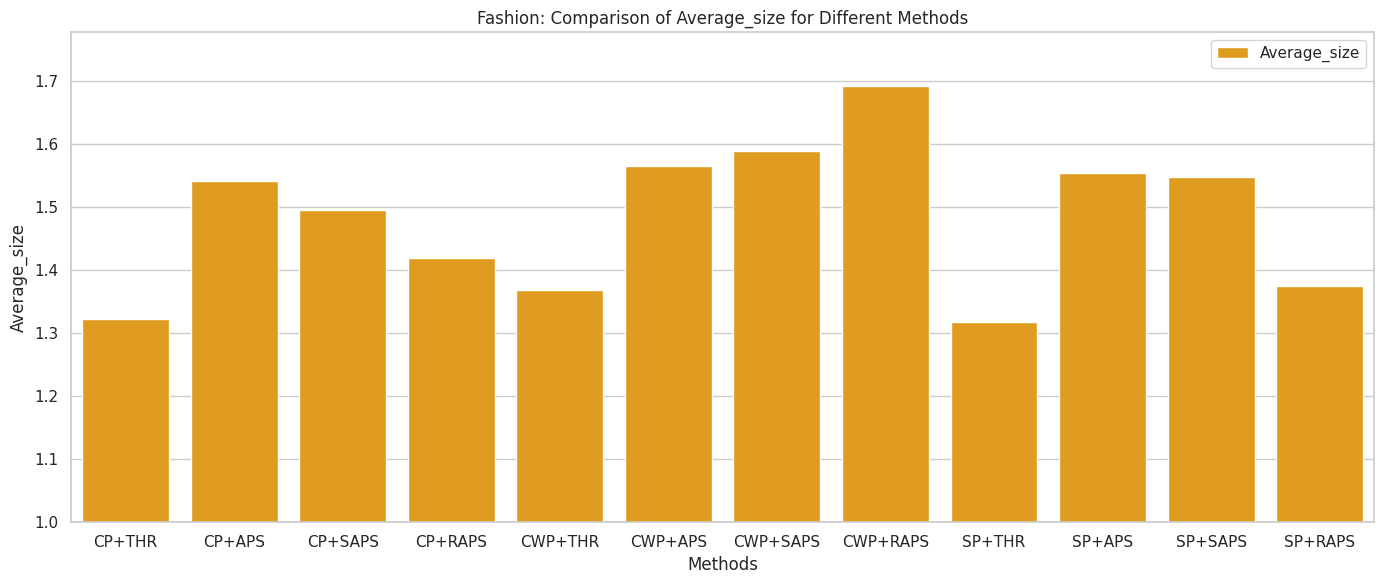

In [36]:
sns.set_theme()
sns.set(style="whitegrid", palette="deep")

plt.figure(figsize=(14, 6))

sns.barplot(x=setting1, y=Average_sizes1,  color='orange', label='Average_size')
#sns.barplot(x='Model', y='Top-3 Accuracy', data=df, color='orange', label='Top-3 Accuracy')

plt.xlabel('Methods')
plt.ylabel('Average_size')
plt.title('Fashion: Comparison of Average_size for Different Methods')
# plt.xticks(rotation=45, ha='right')
plt.ylim(1,)
plt.legend()

plt.tight_layout()
plt.show()

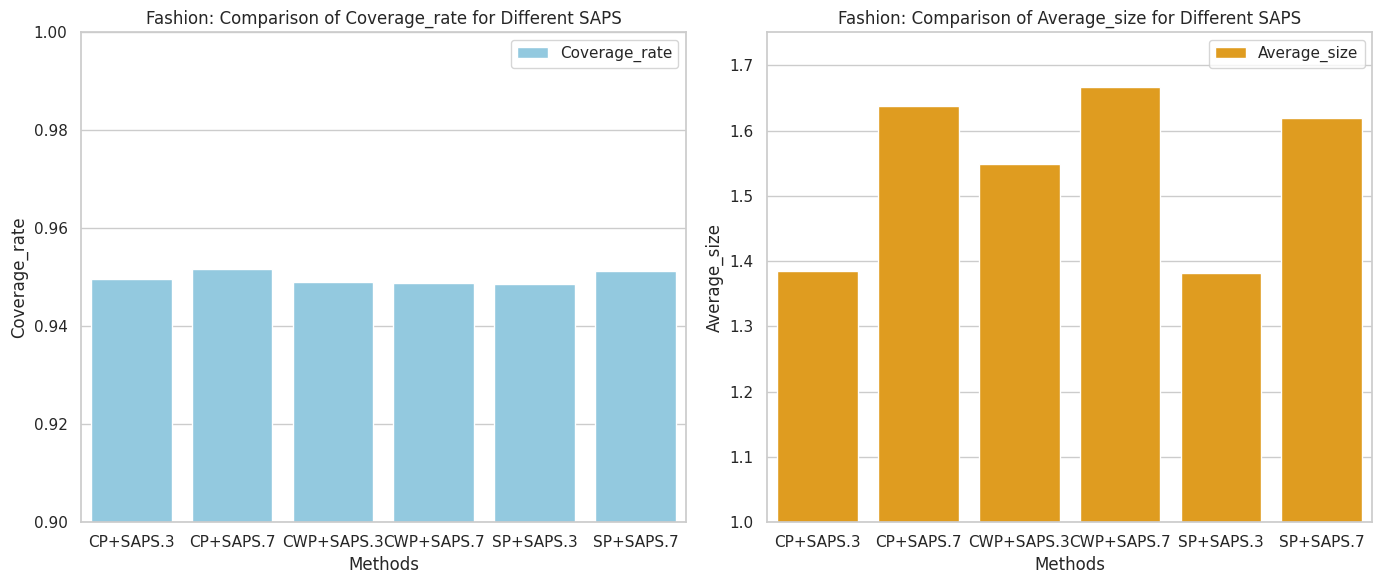

In [38]:
sns.set_theme()
sns.set(style="whitegrid", palette="deep")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=setting2, y=Coverage_rates2,  color='skyblue', label='Coverage_rate')

plt.xlabel('Methods')
plt.ylabel('Coverage_rate')
plt.title('Fashion: Comparison of Coverage_rate for Different SAPS')
# plt.xticks(rotation=45, ha='right')
plt.ylim(0.9,1)
plt.legend()

plt.subplot(1,2,2)
sns.barplot(x=setting2, y=Average_sizes2,  color='orange', label='Average_size')
#sns.barplot(x='Model', y='Top-3 Accuracy', data=df, color='orange', label='Top-3 Accuracy')

plt.xlabel('Methods')
plt.ylabel('Average_size')
plt.title('Fashion: Comparison of Average_size for Different SAPS')
# plt.xticks(rotation=45, ha='right')
plt.ylim(1,)
plt.legend()

plt.tight_layout()
plt.show()

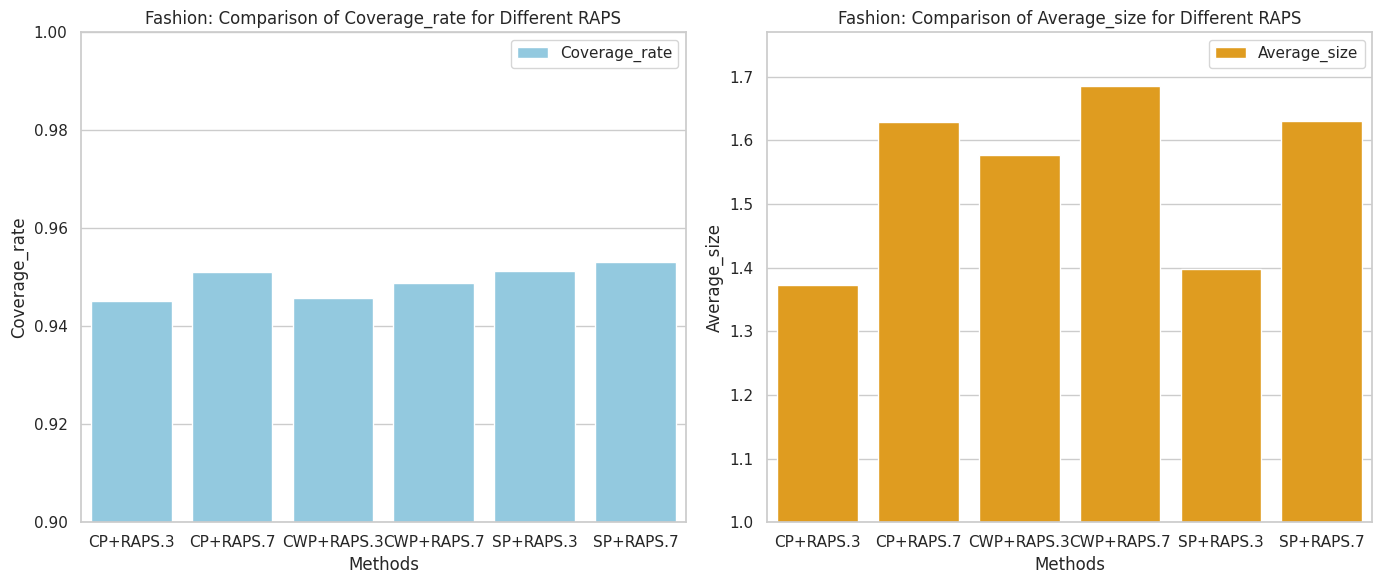

In [40]:
sns.set_theme()
sns.set(style="whitegrid", palette="deep")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=setting3, y=Coverage_rates3,  color='skyblue', label='Coverage_rate')

plt.xlabel('Methods')
plt.ylabel('Coverage_rate')
plt.title('Fashion: Comparison of Coverage_rate for Different RAPS')
# plt.xticks(rotation=45, ha='right')
plt.ylim(0.9,1)
plt.legend()

plt.subplot(1,2,2)
sns.barplot(x=setting3, y=Average_sizes3,  color='orange', label='Average_size')
#sns.barplot(x='Model', y='Top-3 Accuracy', data=df, color='orange', label='Top-3 Accuracy')

plt.xlabel('Methods')
plt.ylabel('Average_size')
plt.title('Fashion: Comparison of Average_size for Different RAPS')
# plt.xticks(rotation=45, ha='right')
plt.ylim(1,)
plt.legend()

plt.tight_layout()
plt.show()